In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sparse_rf.algs.core import min_wl2, min_l2, min_l1
from sparse_rf.modules import make_X, make_W, make_A
from sparse_rf.util import *
from sparse_rf.util.fns import *
from functools import partial
import numpy.linalg as la
import random
import gc

In [2]:
def prune(w, A_train, A_test, y_train, y_test, method, per=20):
    thre = np.percentile(np.abs(w), per)
    idx = np.abs(w) > thre
    # output mse after pruninig--bad results
    y_pred = A_test[:, idx] @ w[idx]
    mse_prune = 1/len(y_test) * la.norm(y_pred - y_test)**2
    # print(f"mse after prunining with threshold {thre}: {mse_prune}")

    # retraining--IMP--good resultS
    A_trains = A_train[:, idx]
    A_tests = A_test[:, idx]
    w_prune = method(A_trains, y_train)
    y_preds = A_tests @ w_prune
    mse_retrain = 1/len(y_test) * la.norm(y_preds - y_test)**2
    print(f"mse after training with {w_prune.shape}")

    return A_trains, A_tests, w_prune, mse_prune, mse_retrain

def prune_total(A_train_sparse, A_test_sparse, y_train, y_test, c_l2_sparse, method, step=30, per=20):
    A_trains, A_tests, w_prune = A_train_sparse, A_test_sparse, c_l2_sparse
    mse_prune = []
    mse_retrain = []
    w_length = []

    for i in range(step):
        A_trains, A_tests, w_prune, msep, mser = prune(w_prune, A_trains, A_tests, y_train, y_test, method, per)
        mse_prune.append(msep)
        mse_retrain.append(mser)
        w_length.append(w_prune.shape[0])

    return w_length, mse_prune, mse_retrain

# double descent curve plot with randomly sampled weights
def reinit(X_train, X_test, y_train, y_test, d, q, method, w_length):
    res_reinit = []
     # new initialization
    for wl in w_length:
        W_sparse = make_W(d, q, N=wl//2, dist=normal)
        A_train_sparse = make_A(X_train, W_sparse, active=active)
        A_test_sparse = make_A(X_test, W_sparse, active=active)
        # print(A_train_sparse.shape, wl)

        c = method(A_train_sparse, y_train)
        res = np.linalg.norm(A_test_sparse@c-y_test)**2 / len(y_test)
        res_reinit.append(res)
    return res_reinit 

In [3]:
def test_perfomance(d, qs, N, m, func, ratio_train):
    X = make_X(d, m, dist=uniform)
    X_train = X[:int(m*ratio_train), :]
    X_test = X[int(m*ratio_train):, :]

    y = np.array(list(map(func, X)))
    y_train = y[:int(m*ratio_train)]
    y_test = y[int(m*ratio_train):]

    seeds = [13]

    results_l1 = []
    results_l2 = []
    prune_result = []
    w_result = []
    for q in qs:
        res_l1 = []
        res_l2 = []
        res_prune = []
        w_len = []
        
        for seed in seeds:
            random.seed(seed)
            np.random.seed(seed)

            W = make_W(d, q, N=N, dist=partial(normal, stdev=1))
            A_train = make_A(X_train, W, active=active)
            A_test = make_A(X_test, W, active=active)

            c_l1 = min_l1(A_train, y_train)
            c_l2 = min_l2(A_train, y_train)

            res_l1.append(np.linalg.norm(A_test@c_l1 - y_test) / np.linalg.norm(y_test))
            res_l2.append(np.linalg.norm(A_test@c_l2 - y_test) / np.linalg.norm(y_test))

            w_length, mse_prune, mse_retrain = prune_total(A_train, A_test, y_train, y_test, c_l2, method=min_l2, step=30, per=20)
            idx = np.argmin(mse_retrain)
            res_prune.append(mse_retrain[idx])
            w_len.append(w_length[idx])


            del W
            del A_train
            del A_test
            del c_l1
            del c_l2

            gc.collect()

        results_l1.append(res_l1)
        results_l2.append(res_l2)
        prune_result.append(res_prune)
        w_result.append(w_len)


    return X_train, X_test, y_train, y_test, results_l1, results_l2, prune_result, w_result, w_length


In [8]:
def plot_results(results_l1, results_l2, prune_result, w_result, func_name, d):
    print("{}, l1: {}".format(func_name, [np.mean(res) for res in results_l1]))
    print("{}, l2: {}".format(func_name, [np.mean(res) for res in results_l2]))
    print("{}, l2_prune: {}".format(func_name, [np.mean(res) for res in prune_result]))
    plt.loglog(qs, [np.mean(res) for res in results_l1], '*-', label="l1")
    plt.loglog(qs, [np.mean(res) for res in results_l2], '.-', label="l2")
    plt.loglog(qs, [np.mean(res) for res in prune_result], 'o-', label="pruned l2")
    plt.title(f"{func_name}")
    plt.xlabel("q")
    plt.ylabel("test error")
    plt.legend()
    plt.savefig(f"./figs/d_{d}/{func_name}_d{d}_l1_l2_prune_test_error.png", bbox_inches="tight", dpi=200)
    plt.show()

    plt.loglog(qs, w_result, 'go--', label="l2")
    plt.ylabel("N_prune")
    plt.xlabel("q")
    plt.title(f"{func_name}")
    plt.savefig(f"./figs/d_{d}/{func_name}_d{d}_l2_prune_N.png", bbox_inches="tight", dpi=200)
    plt.show()

In [9]:
def get_double_descent_curve(X_train, X_test, y_train, y_test, w_length, qs, d, func_name):
    res_re = []
    for q in qs:
        print(q)
        res_reinit = reinit(X_train, X_test, y_train, y_test, d, q, min_l2, w_length)
        res_re.append(res_reinit)
    for i, q in enumerate(qs):
        plt.loglog(w_length, res_re[i], '-.', label="q={}, min={:.2e}".format(q, min(res_re[i])))
    plt.ylabel("test error")
    plt.xlabel("#features")
    plt.title(f"{func_name}")
    plt.legend()
    plt.savefig(f"./figs/d_{d}/{func_name}_d{d}_l2_dd.png", bbox_inches="tight", dpi=200)
    plt.show()

In [10]:
# set up parameters
m = 1000
d = 5
N = 10000
active = fourier

ratio_train = 0.7
qs = [1, 2, 3, 4, 5, 20, 100] if d == 100 else [1, 2, 3, 4, 5]

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
mse after training with (16000,)
mse after training with (12800,)
mse after training with (10240,)
mse after training with (8192,)
mse after training with (6553,)
mse after training with (5242,)
mse after training with (4193,)
mse after training with (3354,)
mse after training with (2683,)
mse after training with (2146,)
mse after training with (1716,)
mse after training with (1372,)
mse after training with (1097,)
mse aft

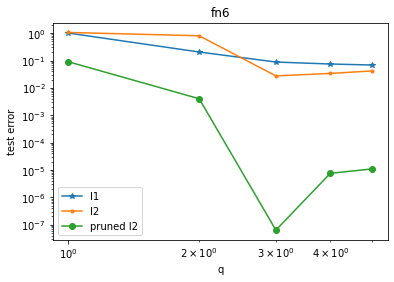

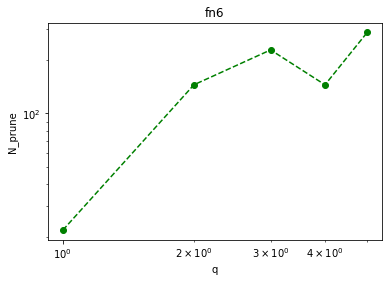

1
2
3
4
5


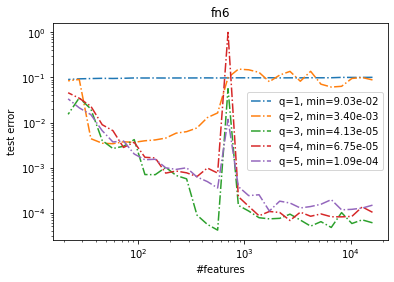

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
mse after training with (16000,)
mse after training with (12800,)
mse after training with (10240,)
mse after training with (8192,)
mse after training with (6553,)
mse after training with (5242,)
mse after training with (4193,)
mse after training with (3354,)
mse after training with (2683,)
mse after training with (2146,)
mse after training with (1716,)
mse after training with (1372,)
mse after training with (1097,)
mse aft

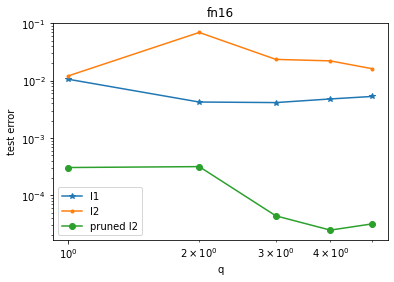

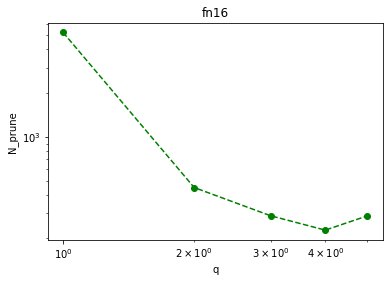

1
2
3
4
5


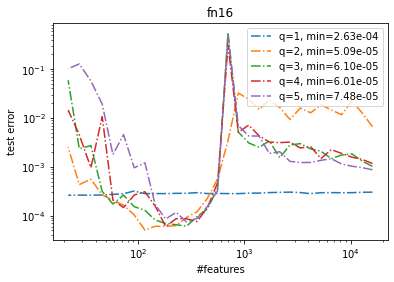

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
mse after training with (16000,)
mse after training with (12800,)
mse after training with (10240,)
mse after training with (8192,)
mse after training with (6553,)
mse after training with (5242,)
mse after training with (4193,)
mse after training with (3354,)
mse after training with (2683,)
mse after training with (2146,)
mse after training with (1716,)
mse after training with (1372,)
mse after training with (1097,)
mse aft

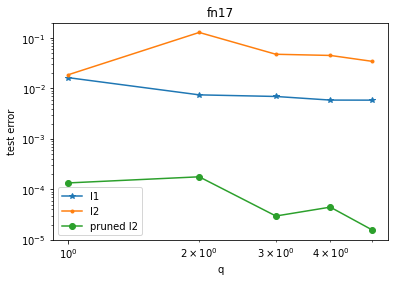

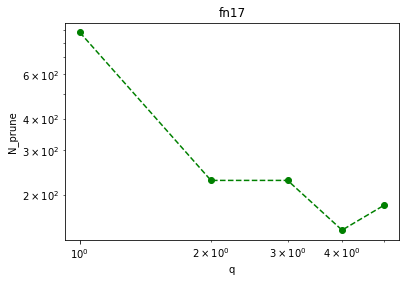

1
2
3
4
5


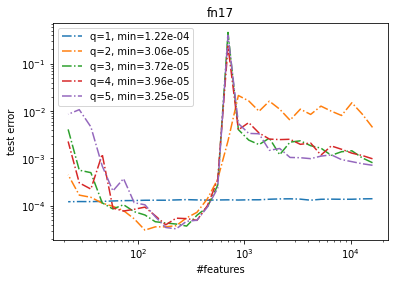

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
mse after training with (16000,)
mse after training with (12800,)
mse after training with (10240,)
mse after training with (8192,)
mse after training with (6553,)
mse after training with (5242,)
mse after training with (4193,)
mse after training with (3354,)
mse after training with (2683,)
mse after training with (2146,)
mse after training with (1716,)
mse after training with (1372,)
mse after training with (1097,)
mse aft

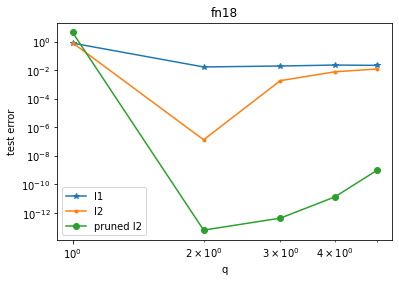

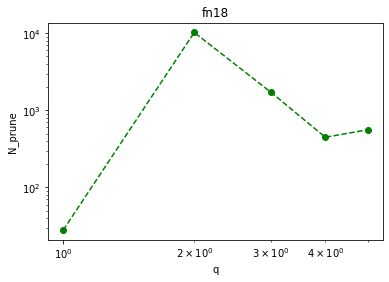

1
2
3
4
5


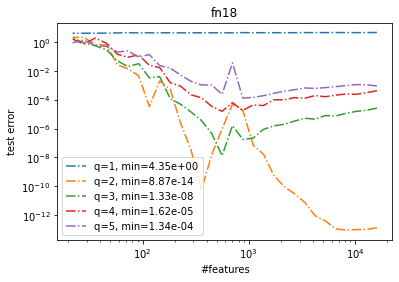

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
mse after training with (16000,)
mse after training with (12800,)
mse after training with (10240,)
mse after training with (8192,)
mse after training with (6553,)
mse after training with (5242,)
mse after training with (4193,)
mse after training with (3354,)
mse after training with (2683,)
mse after training with (2146,)
mse after training with (1716,)
mse after training with (1372,)
mse after training with (1097,)
mse aft

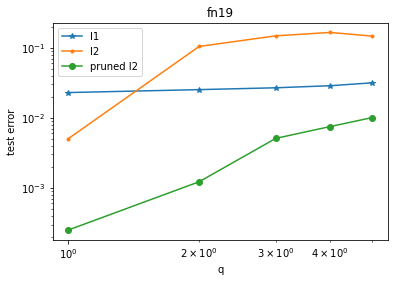

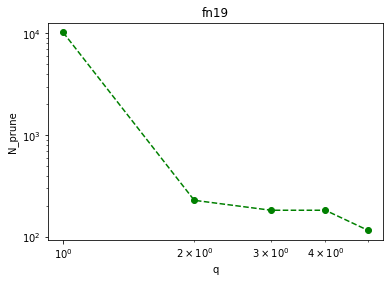

1
2
3
4
5


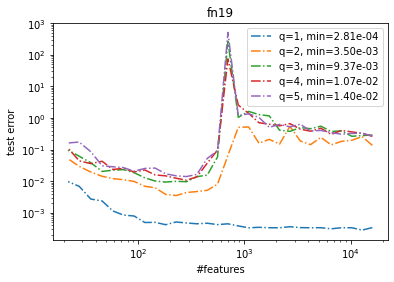

In [11]:
func_dict = {"fn": [fn6, fn16, fn17, fn18, fn19], "name": ["fn6", "fn16", "fn17", "fn18", "fn19"]}
for i in range(len(func_dict["fn"])):
    X_train, X_test, y_train, y_test, results_l1, results_l2, prune_result, w_result, w_length = test_perfomance(d, qs, N, m, func_dict["fn"][i], ratio_train)
    plot_results(results_l1, results_l2, prune_result, w_result, func_dict["name"][i], d)
    get_double_descent_curve(X_train, X_test, y_train, y_test, w_length, qs, d, func_dict["name"][i])